# **Breast Cancer classification using Binary Logistic Regression w/ Tikhonov Normalization**

In [37]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11.4"):
    print(FAIL, "Python version 3.11.4 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.7.2", 'numpy': "1.24.4",'sklearn': "1.3.0", 
                'pandas': "2.0.3", 'pytest': "7.2.1"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] numpy version 1.24.4 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] pytest version 7.2.1 is installed.



### Introduction
This classification task is to predict whether or not a given patient has breast cancer based on health data. The regularization method that you will be using is Tikhonov
regularization (L2 norm). It also features cross-validation.

### Stencil Code & Data

We have provided the following stencil code within this file:

-   `models` contains the `RegularizedLogisticRegression` model which
    you will be implementing.
    
-   `main` is the entry point of your program which will read in the
    data, run the classifier and print the results.

-   `Check Model` contains a series of tests to ensure you are coding your 
    model properly.
    
You should not modify any code in the `main`. If you do for debugging
or other purposes, please make sure any additions are commented out in
the final handin. Do not modify or move the `Check Model` cell! If you 
do so, you will lose points. The unit tests in that cell make it easy 
to grade your solution. All the functions you need to fill in reside 
in this notebook, marked by `TODO`s. You can see a full description 
of them in the section below.

### UCI Breast Cancer Wisconsin (Diagnostic) Data Set 

You will use a preprocessed version of the Breast Cancer Wisconsin
(Diagnostic) Data Set from UC Irvine's Machine Learning Repository site.
You can read more about the dataset here at
<https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)>.
We have split it up into train and validation sets already
for you and read them in in `main`.

## **The Assignment**

We provide you with a sigmoid function to use when training your data.
In `models`, there are five functions you will implement. They are:

-   `RegularizedLogisticRegression`:

    -   **`train()`** uses batch stochastic gradient descent to learn
        the weights. You may find your solution from HW03 to be helpful,
        but in this assignment, we will train for a finite number of
        epochs rather than until we reach a particular convergence
        criteria. The weight update step for this assignment will also
        be different from HW03.

    -   **`predict()`** predicts the labels using the inputs of test
        data.

    -   **`accuracy()`** computes the percentage of the correctly
        predicted labels over a dataset.

    -   **`runTrainTestValSplit()`** trains and evaluates for multiple
        values of the hyperparameter lambda. This function evaluates
        models by using train/validation sets, and
        returns lists of training and validation errors with respect to
        each value of lambda.

    -   **`runKFold()`** evaluates models by implementing k-fold cross
        validation, and returns a list of errors with respect to each
        value of lambda. Note that we have defined
        `_kFoldSplitIndices()` for you, which you may find helpful when
        implementing this function.

*Note*: You are not allowed to use any off-the-shelf packages that have
already implemented these models, such as scikit-learn. We're asking you
to implement them yourself.

### **Binary Logistic Regression**

Similar to homework 3, we are again implementing Logistic Regression for
classification. However, note that there are a few key differences. For
this assignment, we are performing binary classification, which is a
special case of multi-class classification. We are also implementing
regularization, so you should think about how you would need to modify
the loss function and gradient provided below to include regularization.
For this problem, there are only two classes, which are denoted by
$\{0, 1\}$ labels.\
Our model will perform the following:

$$h(x) = \frac{1}{1 + e^{-<w, x>}}$$

where $w$ is the model's weights and $h(x)$ is the probability that the
data point $x$ has a label of 1. We have implemented this as
`sigmoid_function()` for you.\
\
Our loss function will be Binary Log Loss, also called Binary Cross
Entropy Loss:

$$L_S(h) = -\frac{1}{m} \sum_{i=1}^m (y_i \log h(x_i) + (1 - y_i)\log (1 - h(x_i)))$$

on a sample $S$ of $m$ data points. Therefore, the corresponding
gradient of the Binary Log loss with respect to the model's weights is
$$\frac{\partial L_S(h)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (h(x_i) - y_i)x_{ij}$$

### **Regularize with Tikhonov Regularization**

As mentioned in the introduction part, with Tikhonov regularization, you
just need to implement the L2 norm of the weights, which is
$$\lambda||w||_2^2 = \lambda\sum_{i=1}^{d}w_i^2$$ 

With that added, the gradient used to update the weights has to be adjusted to include
$$\frac{\partial \lambda\sum_{i=1}^{d}w_i^2}{\partial w_j} = 2\lambda w_j$$
Notice that the $\lambda$ parameter above is used to control the
contribution of the regularization term to the overall learning process
that you may have to tune a little bit when implementing the code.

## **Model**

In [41]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid_function(x):
    return 1.0 / (1.0 + np.exp(-x))

class RegularizedLogisticRegression(object):
    '''
    Implement regularized logistic regression for binary classification.
    The weight vector w should be learned by minimizing the regularized loss
    L(h, (x,y)) = log(1 + exp(-y <w, x>)) + lambda |w|_2^2. In other words, the objective
    function that we are trying to minimize is the log loss for binary logistic regression 
    plus Tikhonov regularization with a coefficient of lambda.
    '''
    def __init__(self, batch_size = 15):
        self.learningRate = 0.00001 # Feel free to play around with this if you'd like, though this value will do
        self.num_epochs = 10000 # Feel free to play around with this if you'd like, though this value will do
        self.batch_size = batch_size # Feel free to play around with this if you'd like, though this value will do
        self.weights = None
        self.lmbda = 1 # tune this parameter
    
    def train(self, X, Y):
        '''
        Train the model, using batch stochastic gradient descent
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
        @return:
            None
        '''
        self.weights = np.zeros((1, len(X[0])))
        X_copy = X.copy()
        Y_copy = Y.copy()
        for epoch in range(self.num_epochs):
            # Shuffle training examples
            indices = list(range(len(X_copy)))
            random.shuffle(indices)
            X_copy = X_copy[indices]
            Y_copy = Y_copy[indices]
            for i in range(0, (len(X_copy) + self.batch_size - 1) // self.batch_size):
                start = i * self.batch_size
                end = min((i + 1) * self.batch_size, len(X_copy))
                X_batch = X_copy[start:end]
                Y_batch = Y_copy[start:end]
                grad = np.zeros_like(self.weights)
                for x, y in zip(X_batch, Y_batch):
                    h_x = sigmoid_function(np.dot(self.weights, x))
                    grad += (h_x - y) * x
                adjusted_grad = grad / len(X_batch) + 2 * self.lmbda * self.weights
                self.weights -= self.learningRate * adjusted_grad
      

    def predict(self, X):
        '''
        Compute predictions based on the learned parameters and examples X
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
        @return:
            A 1D Numpy array with one element for each row in X containing the predicted class.
        '''
        #[TODO]
        prob = sigmoid_function(np.dot(X, self.weights.T))
        return (prob >= 0.5).astype(int).flatten()

    def accuracy(self,X, Y):
        '''
        Output the accuracy of the trained model on a given testing dataset X and labels Y.
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
        @return:
            a float number indicating accuracy (between 0 and 1)
        '''
        #[TODO]
        predict_labels = self.predict(X)
        correct = np.sum(predict_labels == Y)
        total = len(Y)
        return correct / total

    def runTrainTestValSplit(self, lambda_list, X_train, Y_train, X_val, Y_val):
        '''
        Given the training and validation data, fit the model with training data and test it with
        respect to each lambda. Record the training error and validation error, which are equivalent 
        to (1 - accuracy).
        @params:
            lambda_list: a list of lambdas
            X_train: a 2D Numpy array for trainig where each row contains an example,
            padded by 1 column for the bias
            Y_train: a 1D Numpy array for training containing the corresponding labels for each example
            X_val: a 2D Numpy array for validation where each row contains an example,
            padded by 1 column for the bias
            Y_val: a 1D Numpy array for validation containing the corresponding labels for each example
        @returns:
            train_errors: a list of training errors with respect to the lambda_list
            val_errors: a list of validation errors with respect to the lambda_list
        '''
        train_errors = []
        val_errors = []
        #[TODO] train model and calculate train and validation errors here for each lambda
        for lmbda in lambda_list:
            self.lmbda = lmbda
            self.train(X_train, Y_train)
            train_errors.append(1 - self.accuracy(X_train, Y_train))
            val_errors.append(1 - self.accuracy(X_val, Y_val))
        return train_errors, val_errors

    def _kFoldSplitIndices(self, dataset, k):
        '''
        Helper function for k-fold cross validation. Evenly split the indices of a
        dataset into k groups.
        For example, indices = [0, 1, 2, 3] with k = 2 may have an output
        indices_split = [[1, 3], [2, 0]].
        
        Please don't change this.
        @params:
            dataset: a Numpy array where each row contains an example
            k: an integer, which is the number of folds
        @return:
            indices_split: a list containing k groups of indices
        '''
        num_data = dataset.shape[0]
        fold_size = int(num_data / k)
        indices = np.arange(num_data)
        np.random.shuffle(indices)
        indices_split = np.split(indices[:fold_size*k], k)
        return indices_split

    def runKFold(self, lambda_list, X, Y, k = 3):
        '''
        Run k-fold cross validation on X and Y with respect to each lambda. Return all k-fold
        errors.
        
        Each run of k-fold involves k iterations. For an arbitrary iteration i, the i-th fold is
        used as testing data while the rest k-1 folds are combined as one set of training data. The k results are
        averaged as the cross validation error.
        @params:
            lambda_list: a list of lambdas
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
            k: an integer, which is the number of folds, k is 3 by default
        @return:
            k_fold_errors: a list of k-fold errors with respect to the lambda_list
        '''
        
        k_fold_errors = []
        for lmbda in lambda_list:
            self.lmbda = lmbda
            #[TODO] call _kFoldSplitIndices to split indices into k groups randomly
            indices_split = self._kFoldSplitIndices(X, k)
            #[TODO] for each iteration i = 1...k, train the model using lmbda
            # on k−1 folds of data. Then test with the i-th fold.
            total_error = 0
            for i in range(k):
                val_indices = indices_split[i]
                train_indices = np.concatenate([indices_split[j] for j in range(k) if j != i])
                self.train(X[train_indices], Y[train_indices])
                val_accuracy = self.accuracy(X[val_indices], Y[val_indices])
                val_error = 1 - val_accuracy
                total_error += val_error
            #[TODO] calculate and record the cross validation error by averaging total errors
            k_fold_error = total_error / k
            k_fold_errors.append(k_fold_error)
        return k_fold_errors

    def plotError(self, lambda_list, train_errors, val_errors, k_fold_errors):
        '''
        Produce a plot of the cost function on the training and validation sets, and the
        cost function of k-fold with respect to the regularization parameter lambda. Use this plot
        to determine a valid lambda.
        @params:
            lambda_list: a list of lambdas
            train_errors: a list of training errors with respect to the lambda_list
            val_errors: a list of validation errors with respect to the lambda_list
            k_fold_errors: a list of k-fold errors with respect to the lambda_list
        @return:
            None
        '''
        plt.figure()
        plt.semilogx(lambda_list, train_errors, label = 'training error')
        plt.semilogx(lambda_list, val_errors, label = 'validation error')
        plt.semilogx(lambda_list, k_fold_errors, label = 'k-fold error')
        plt.xlabel('lambda')
        plt.ylabel('error')
        plt.legend()
        plt.show()

## **Check Model**

In [43]:
import pytest
# Sets random seed for testing purposes
np.random.seed(0)
random.seed(0)

# Creates Test Models
test_model1 = RegularizedLogisticRegression(3)
test_model2 = RegularizedLogisticRegression(3)

# Creates Test Data
x_bias = np.array([[0,4,1], [0,3,1], [5,0,1], [4,1,1], [0,5,1]])
y = np.array([0,0,1,1,0])
x_bias_test = np.array([[0,0,1], [-5,3,1], [9,0,1], [1,0,1], [6,-7,1]])
y_test = np.array([0,0,1,0,1])

x_bias2 = np.array([[0,0,1], [0,3,1], [4,0,1], [6,1,1], [0,1,1], [0,4,1]])
y2 = np.array([0,1,1,1,0,1])
x_bias_test2 = np.array([[0,0,1], [-5,-3,1], [9,0,1], [1,0,1]])
y_test2 = np.array([0,0,1,0])


# Test Train Model and Checks Model Weights
test_model1.train(x_bias, y)
weights1 = test_model1.weights
assert isinstance(weights1, np.ndarray)
assert weights1.ndim==2 and weights1.shape == (1,3)
assert weights1 == pytest.approx(np.array([[0.12661045, -0.14658517, -0.01241918]]), 0.05)

test_model2.train(x_bias2, y2)
weights2 = test_model2.weights
assert isinstance(weights2, np.ndarray)
assert weights2.ndim==2 and weights2.shape == (1,3)
assert weights2 == pytest.approx(np.array([[0.11113, 0.08361, 0.01943]]), 0.05) 

# Test Model Predict
predict1 = test_model1.predict(x_bias_test)
assert isinstance(predict1, np.ndarray)
assert predict1.ndim==1 and predict1.shape==(5,)
assert (predict1 == np.array([0, 0, 1, 1, 1])).all()

predict2 = test_model2.predict(x_bias_test2)
assert isinstance(predict2, np.ndarray)
assert predict2.ndim==1 and predict2.shape==(4,)
assert (test_model2.predict(x_bias_test2) == np.array([1, 0, 1, 1])).all()

# Test Model Accuracy
accuracy1 = test_model1.accuracy(x_bias_test, y_test)
assert isinstance(accuracy1, float)
assert accuracy1 == .8

accuracy2 = test_model2.accuracy(x_bias_test2, y_test2)
assert isinstance(accuracy2, float)
assert accuracy2 == .5

from datetime import date
#[TODO] Print your name and the date, using today function from date 
today = date.today()
print(f"Name: Melvin He | Date: {today}")

Name: Melvin He | Date: 2023-10-21


## **Main**

Train Accuracy: 0.9406593406593406
Validation Accuracy: 0.9649122807017544


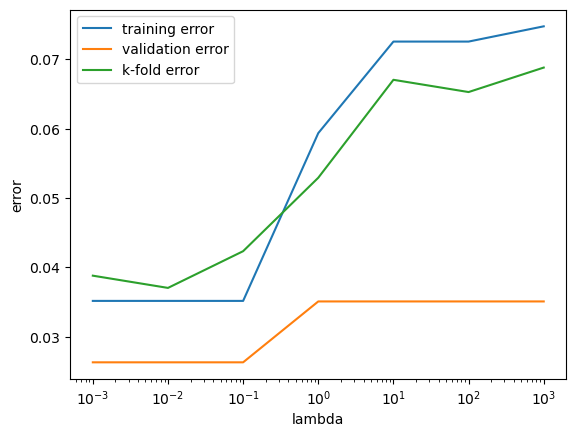

In [44]:
def extract():
    X_train = pd.read_csv('data/X_train.csv',header=None)
    Y_train = pd.read_csv('data/y_train.csv',header=None)
    X_val = pd.read_csv('data/X_val.csv',header=None)
    Y_val = pd.read_csv('data/y_val.csv',header=None)

    Y_train = np.array([i[0] for i in Y_train.values])
    Y_val = np.array([i[0] for i in Y_val.values])

    X_train = np.append(X_train, np.ones((len(X_train), 1)), axis=1)
    X_val = np.append(X_val, np.ones((len(X_val), 1)), axis=1)

    return X_train, X_val, Y_train, Y_val

def main():
    X_train, X_val, Y_train, Y_val = extract()
    X_train_val = np.concatenate((X_train, X_val))
    Y_train_val = np.concatenate((Y_train, Y_val))

    RR = RegularizedLogisticRegression()
    RR.train(X_train, Y_train)
    print('Train Accuracy: ' + str(RR.accuracy(X_train, Y_train)))
    print('Validation Accuracy: ' + str(RR.accuracy(X_val, Y_val)))

    #[TODO] Once implemented, uncomment the following lines of code and:
    # 1. implement runTrainTestValSplit to get the training and validation errors of our 70-15-15
    #    split to the original dataset
    # 2. implement runKFold to generate errors of each lambda, where k = 3 in this assignment
    # 3. call plotError to plot those errors with respect to lambdas
    
    lambda_list = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
    train_errors, val_errors = RR.runTrainTestValSplit(lambda_list, X_train, Y_train, X_val, Y_val)
    k_fold_errors = RR.runKFold(lambda_list, X_train_val, Y_train_val, 3)
    RR.plotError(lambda_list, train_errors, val_errors, k_fold_errors)
    
    
# Set random seeds. DO NOT CHANGE THIS IN YOUR FINAL SUBMISSION.
np.random.seed(0)
random.seed(0)
main()


**Usage:**
I used batch stochastic gradient descent with regularization to learn the weights similar to hw3, but with several adjustments. This time, the loss function with regularization would be implemented as $$L_S(h) = -\frac{1}{m} \sum_{i=1}^m (y_i \log h(x_i) + (1 - y_i)\log (1 - h(x_i)))$$ and so the partial derivative of the loss with respect to w_j is $$\frac{\partial L_S(h)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (h(x_i) - y_i)x_{ij}$$. In addition, to make sure that I'm implementing Tikhonov Regularizaiton properly, I have to update by adding a 2 * lambda * weights term before decrementing by the learning rate multiplied by the loss. I also did this whole process with min-batches to improve regularizaiton and efficiency.

**Solution:**

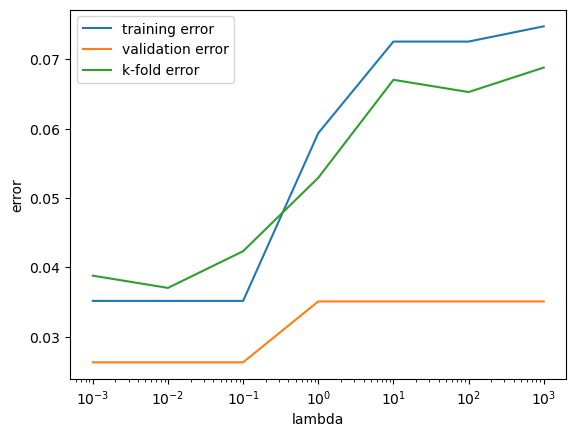

The best value of lambda would be 10^-2 since the k-fold error is at a local minima (note the V-shaped dip) there. 

When splitting our train-validation-test data for patients that might've had multiple samples collected and entered into the dataset, we need to account for this! This is because each patient's samples would be strongly correlated with each other (they come from same person) and won't be appropriately iid. One way to account for this may be to split based on each individual patient by some sort of id instead of their individual samples that may be strongly correlated.